# BERT
as implemented with guidance of Tensorflow tutorial https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [1]:
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"
!pip install seaborn
!pip install tabulate

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 34.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 9.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 48.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.2 MB/s eta 0:00:00
   ━━━

In [54]:
import os
import pandas as pd
import shutil
import csv
import re
import random

from tabulate import tabulate
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

tf.get_logger().setLevel('ERROR')

In [55]:
# import data and create data sets
train = pd.read_csv("1_Data/Raw_Data/train_preprocessed.csv")
test = pd.read_csv("1_Data/Raw_Data/test_preprocessed.csv")
val = pd.read_csv("1_Data/Raw_Data/dev_preprocessed.csv")


Xtest = test['text']
ytest = test['label']
Xtrain = train['text']
ytrain = train['label']
Xval = val['text']
yval = val['label']

batch_size = 32
test_ds = tf.data.Dataset.from_tensor_slices((Xtest.values, ytest.values)).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((Xtrain.values, ytrain.values)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((Xval.values, yval.values)).batch(batch_size)

## Import BERT Models

In [56]:
# Load the BERT preprocessing model and the BERT encoder model from TensorFlow Hub
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

#define models
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder_model = hub.KerasLayer(tfhub_handle_encoder)

## Define Model

In [57]:
# define model architecture
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier',kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
  return tf.keras.Model(text_input, net)

In [58]:
# create model by calling function
classifier_model = build_classifier_model()

## Compile the model

In [59]:
# binary classification problem
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
epochs = 10

# compile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

## Train the model

In [60]:
# implement early stopping to stop training in case loss does not decrease further
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[early_stopping,lr_schedule])

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
70/70 [==============================] - 245s 3s/step - loss: 0.3573 - binary_accuracy: 0.8426 - val_loss: 1.9839 - val_binary_accuracy: 0.4151 - lr: 5.0000e-05
Epoch 2/10
70/70 [==============================] - 225s 3s/step - loss: 0.3167 - binary_accuracy: 0.8883 - val_loss: 0.4536 - val_binary_accuracy: 0.8377 - lr: 5.0000e-05
Epoch 3/10
70/70 [==============================] - 222s 3s/step - loss: 0.1864 - binary_accuracy: 0.9399 - val_loss: 0.2783 - val_binary_accuracy: 0.9094 - lr: 5.0000e-05
Epoch 4/10
70/70 [==============================] - 222s 3s/step - loss: 0.1033 - binary_accuracy: 0.9731 - val_loss: 0.3297 - val_binary_accuracy: 0.9057 - lr: 5.0000e-05
Epoch 5/10
70/70 [==============================] - 223s 3s/step - loss: 0.0842 - binary_accuracy: 0.9798 - val_loss: 0.3490 - val_binary_accuracy: 0.9019 - lr: 5.0000e-05
Epoch 6/10
70/70 [==============================] - 222s 

In [61]:
# print loss and accuracy for test set
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

9/9 [==============================] - 8s 863ms/step - loss: 0.3401 - binary_accuracy: 0.9170
Loss: 0.34013333916664124
Accuracy: 0.9169811606407166


## Plot training

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'lr'])


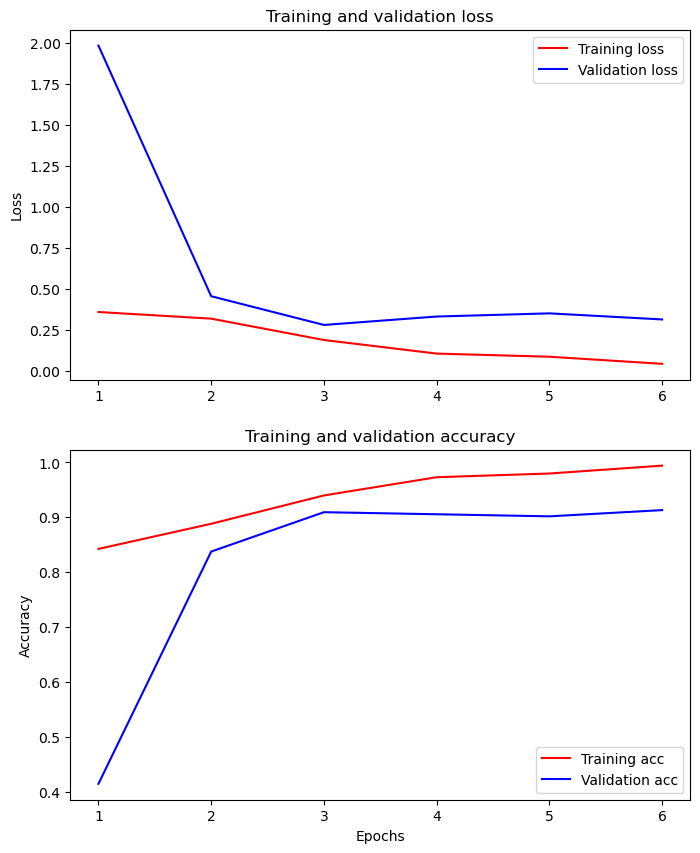

In [62]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(8,10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Confusion Matrix

In [97]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


# Evaluate the model and print metrics
def evaluate_and_print_metrics(model, test_ds):
    y_true = []
    y_pred = []

    for x, y in test_ds:
        y_true.extend(y.numpy())
        predictions = model.predict(x)
        y_pred.extend(np.round(predictions).astype(int).flatten())

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Compute and print classificatin report
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)
    
    # Compute and print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, ['Class 0', 'Class 1'])
    

1/1 [==============================] - 0s 422ms/step
Accuracy: 0.9170
Precision: 0.7778
Recall: 0.9403
F1 Score: 0.8514
              precision    recall  f1-score   support

     Class 0       0.98      0.91      0.94       198
     Class 1       0.78      0.94      0.85        67

    accuracy                           0.92       265
   macro avg       0.88      0.92      0.90       265
weighted avg       0.93      0.92      0.92       265



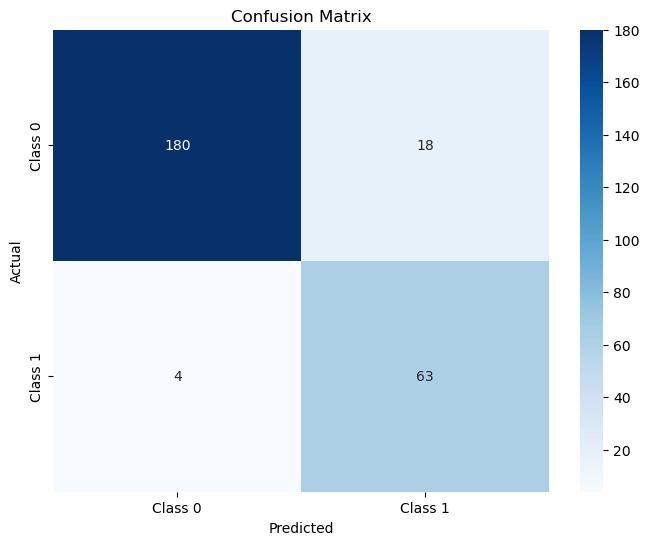

In [98]:
evaluate_and_print_metrics(classifier_model, test_ds)

## Predict DAX Annual Reports

### Get environmental claims for one company

In [109]:
file_path = '1_Data/Annual Reports_csv/BASF_2023.csv'

# Initialize an empty list to store the rows
data_list = []

# Open the CSV file and read its contents
with open(file_path, mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        data_list.append(row)

#make predictions and convert the sigmoid probability into binary classes
preds = classifier_model.predict(data_list)
y_classes = ((preds > 0.5)+0).ravel()

# Store every data_list object where y_classes = 1 in a list called "environmental_claims"
environmental_claims = [data_list[i] for i in range(len(y_classes)) if y_classes[i] == 1]
non_environmental_claims = [data_list[i] for i in range(len(y_classes)) if y_classes[i] == 0]

# Print the number of environmental claims
print(f"Number of environmental claims: {len(environmental_claims)}")


171/171 [==============================] - 161s 943ms/step
Number of environmental claims: 607


### Print Random Sentences

In [113]:
# Check if there are at least 10 items in each list
if len(environmental_claims) >= 5:
    random_environmental_claims = random.sample(environmental_claims, 5)
else:
    random_environmental_claims = environmental_claims

if len(non_environmental_claims) >= 5:
    random_non_environmental_claims = random.sample(non_environmental_claims, 5)
else:
    random_non_environmental_claims = non_environmental_claims

# Print 5 random objects from each list
print("5 Random Environmental Claims:")
for claim in random_environmental_claims:
    print(claim)

print("\n5 Random Non-Environmental Claims:")
for claim in random_non_environmental_claims:
    print(claim)

5 Random Environmental Claims:
['BASF France SAS \n \nis part of the Entreprises pour l’Environnement network, which \n \nlaunched the Act4nature campaign with the main objective of \n \nprotecting and enhancing biodiversity.']
['Recooling also reduces thermal emissions when we return the \ncooling water to the waterways.']
['The aim is to obtain constructive feedback and specific advice on \n \nnature-related topics and our strategic approach as well as our \n \ncontributions to a sustainable future.']
['In the \nsite-specific initiative to save and recycle water, we are focusing  \non increasing the reuse of wastewater, condensate and collected \nrainwater.']
['In cooperation \nwith local farmers and NGOs, BASF’s program promotes the \n \npreservation of biodiverse habitats, as well as good agricultural \npractices, gender equity and fair working conditions.']

5 Random Non-Environmental Claims:
['A complete overview of BASF SE’s operating business is provided by the Consolidated \n 

### Get environment claims for all companies in folder "annual_reports"

In [75]:
directory_path = '1_Data/Annual Reports_csv'

# Initialize an empty list to store the number of claims along with filenames
claims_count_list = []

# Loop through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        
        # Initialize an empty list to store the rows
        data_list = []

        # Open the CSV file and read its contents
        with open(file_path, mode='r', newline='') as file:
            reader = csv.reader(file)
            for row in reader:
                data_list.append(row)

        # Make predictions and convert the sigmoid probability into binary classes
        print(f"Number of claims in {filename} are now predicted.")
        preds = classifier_model.predict(data_list)
        y_classes = ((preds > 0.5) + 0).ravel()

        # Store every data_list object where y_classes = 1 in a list called "environmental_claims"
        environmental_claims = [data_list[i] for i in range(len(y_classes)) if y_classes[i] == 1]

        # Store the filename and the number of environmental claims
        claims_count_list.append((filename, len(environmental_claims)))

# Print the results
for filename, num_claims in claims_count_list:
    print(f"{filename} - Number of environmental claims: {num_claims}")


Number of claims in DGB_2023.csv are now predicted.
105/105 [==============================] - 99s 939ms/step
Number of claims in SAP_2023.csv are now predicted.
99/99 [==============================] - 94s 951ms/step
Number of claims in DHL_Group_2023.csv are now predicted.
102/102 [==============================] - 96s 943ms/step
Number of claims in Adidas_2023.csv are now predicted.
115/115 [==============================] - 108s 943ms/step
Number of claims in Munich_Re_2023.csv are now predicted.
149/149 [==============================] - 141s 947ms/step
Number of claims in Beiersdorf_2023.csv are now predicted.
142/142 [==============================] - 135s 947ms/step
Number of claims in Siemens_2023.csv are now predicted.
101/101 [==============================] - 95s 941ms/step
Number of claims in Siemens_Energy_2023.csv are now predicted.
110/110 [==============================] - 105s 952ms/step
Number of claims in Qiagen_2023.csv are now predicted.
115/115 [=================

### Print Environmental Claims Count

In [80]:
# Remove "_2023.csv" from each filename and sort the list in descending order
claims_count_list = [(re.sub(r'_2023.*', '', filename), count) for filename, count in claims_count_list]
claims_count_list = sorted(claims_count_list, key=lambda x: x[1], reverse=True)

# Convert to a pretty table
table = tabulate(claims_count_list, headers=["Filename", "Number of Environmental Claims"], tablefmt="pretty")

# Print the table
print(table)

+----------------------+--------------------------------+
|       Filename       | Number of Environmental Claims |
+----------------------+--------------------------------+
|         BASF         |              607               |
| Heidelberg_Materials |              597               |
|      Beiersdorf      |              373               |
|         EON          |              350               |
|  Commerzbank Group   |              304               |
|    Daimler_Truck     |              296               |
|    Allianz_Group     |              253               |
|         RWE          |              227               |
|        Merck         |              218               |
|       Symrise        |              216               |
|      Volkswagen      |              210               |
|      BMW_Group       |              210               |
|       Telekom        |              197               |
|        Adidas        |              162               |
|        Bayer

### Plot Environmental Claim Counts

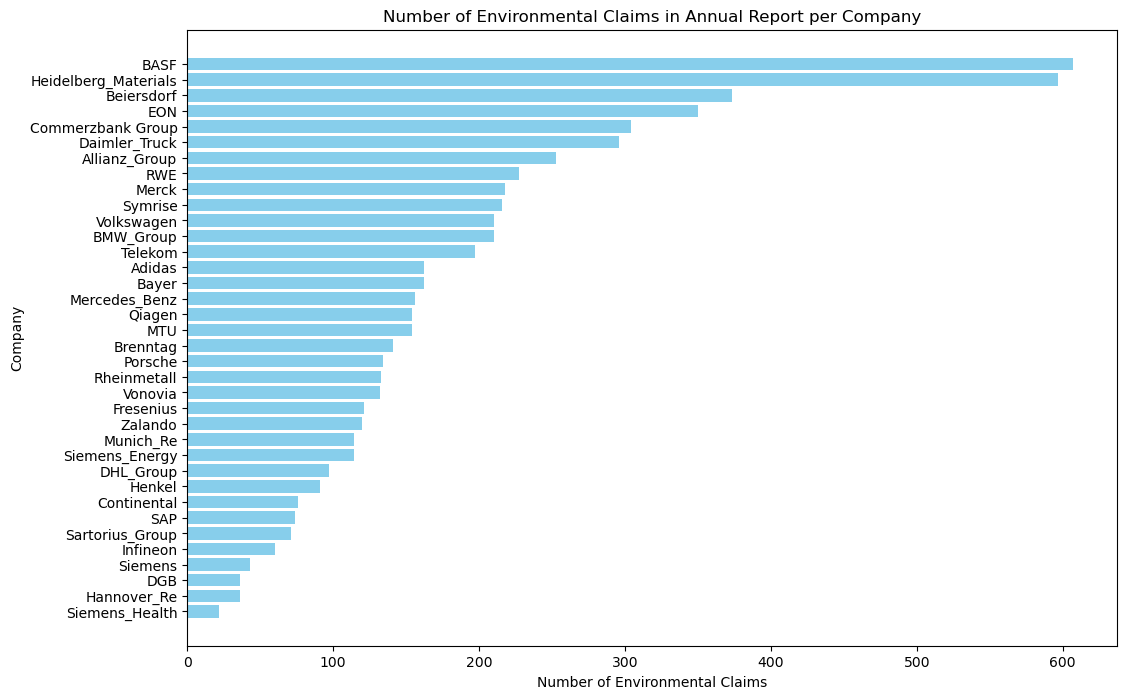

In [101]:
# Extract filenames and number of claims
filenames = [item[0] for item in claims_count_list]
num_claims = [item[1] for item in claims_count_list]

# Plotting the bar graph
plt.figure(figsize=(12, 8))
plt.barh(filenames, num_claims, color='skyblue')
plt.xlabel('Number of Environmental Claims')
plt.ylabel('Company')
plt.title('Number of Environmental Claims in Annual Report per Company')
plt.gca().invert_yaxis()  # To display the largest bar on top
plt.show()

### File Lengths

In [115]:
file_lengths = []

# Loop through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        
        # Initialize an empty list to store the rows
        data_list = []

        # Open the CSV file and read its contents
        with open(file_path, mode='r', newline='') as file:
            reader = csv.reader(file)
            for row in reader:
                data_list.append(row)

        # Append the filename and its length to the list
        file_lengths.append((filename, len(data_list)))

# Sort the list by the lengths in descending order
file_lengths = sorted(file_lengths, key=lambda x: x[1], reverse=True)

# Print the table using tabulate
print("File Lengths in Descending Order:")
table = tabulate(file_lengths, headers=["Filename", "Number of Sentences"], tablefmt="pretty")
print(table)

File Lengths in Descending Order:
+-------------------------------+---------------------+
|           Filename            | Number of Sentences |
+-------------------------------+---------------------+
|       Telekom_2023.csv        |        7023         |
|      Fresenius_2023.csv       |        6805         |
|      Volkswagen_2023.csv      |        6279         |
|  Commerzbank Group_2023.csv   |        5892         |
| Heidelberg_Materials_2023.csv |        5636         |
|         BASF_2023.csv         |        5457         |
|         EON_2023.csv          |        5421         |
|        Merck_2023.csv         |        4892         |
|    Allianz_Group_2023.csv     |        4879         |
|    Daimler_Truck_2023.csv     |        4839         |
|      BMW_Group_2023.csv       |        4780         |
|      Munich_Re_2023.csv       |        4762         |
|    Mercedes_Benz_2023.csv     |        4620         |
|      Beiersdorf_2023.csv      |        4514         |
|         RWE_

### Output claims counts as csv for further analysis

In [116]:
output_csv = 'environmental_claims_counts.csv'

# Write the list to a CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Number of Sentences"])  # Write the header
    writer.writerows(claims_count_list)  # Write the data

print(f"Data has been written to {output_csv}")

Data has been written to environmental_claims_counts.csv


### Get False-Negative and False_positive

In [132]:
# Function to evaluate the model and print metrics
def get_text_classifications(model, test_ds, data_list):
    y_true = []
    y_pred = []

    for x, y in test_ds:
        y_true.extend(y.numpy())
        predictions = model.predict(x)
        y_pred.extend(np.round(predictions).astype(int).flatten())

    # Get the indices of TP, TN, FP, FN
    tp_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == 1 and pred == 1]
    tn_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == 0 and pred == 0]
    fp_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == 0 and pred == 1]
    fn_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == 1 and pred == 0]

    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []
    
    # Print actual values corresponding to the indices
    for i in tp_indices:
        tp_list.append(data_list[i])
    print(f"length tp:{len(tp_list)}")

    for i in tn_indices:
        tn_list.append(data_list[i])
    print(f"length tn:{len(tn_list)}")

    for i in fp_indices:
        fp_list.append(data_list[i])
    print(f"length fp:{len(fp_list)}")

    for i in fn_indices:
        fn_list.append(data_list[i])
    print(f"length fn:{len(fn_list)}")

    return tn_list, fp_list, fn_list, tp_list
# Assuming test_ds is defined and contains the test dataset
tn, fp, fn, tp = get_text_classifications(classifier_model, test_ds, Xtest)


1/1 [==============================] - 0s 420ms/step
length tp:63
length tn:180
length fp:18
length fn:4


### Print False Negatives

In [133]:
fn

['A total population of 6148 is getting the benefit of safe potable drinking water due to this initiative.',
 'To strengthen its approach, Kering’s SBT for a 1.5°C trajectory was revised and approved by the SBTi in early 2021.',
 'In October 2018, EnBW published its first Green Financing Framework and issued its first green bond (Glossary, p. 153) with a volume of €500 million (p. 85 f.).',
 'The SEH Committee will continue to monitor our environmental sustainability performance quarterly and approve updates to our environmental sustainability strategy and targets annually.']

### Print False Positives

In [134]:
fp

["But it's certainly a hefty investment that needs to be made in our state for renewable energy in order to meet that portfolio of standard.",
 'In common with other UK pension schemes, whilst the fund is invested in oil, gas and other resource companies, the fund is also made up of significant holdings in renewable energy assets.',
 'The redevelopment also features Hammerson’s second carbon neutral Costa Eco Pod and the first Denny’s American Diner in the UK.',
 'This reduces KLP’s climate risk and makes it clear that our work has an effect on the climate.',
 'In terms of initiatives regarding energy issues, the AGC Group works to reduce the energy involved in its production activities.',
 'Pursuant to the service concession arrangements, the Group was granted rights to construct, operate and maintain environmental energy projects, greentech projects and environmental water projects in the PRC for a period of 7 to 50 years.',
 'In fact, it is one of the original sources of clean energ